In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
import os

Using TensorFlow backend.


In [2]:
folder='EMG_data_for_gestures-master'
dirlist = os.listdir(folder)
dirlist.remove('README.txt')
l = []
order=[]
for dirn in dirlist:
    for file in os.listdir(folder + '/' + dirn):
        df = pd.read_csv(folder + '/' + dirn + '/' + file, sep='\t')
        l.append(df)
        order.append((dirn,file))


In [3]:
#trash dataframe
l.pop(63)
order.pop(63)

('13', '1_raw_data_13-26_21.03.16.txt')

In [4]:
# def plot_channels(data, gesture):
#     c=data[data['class']==gesture].drop(columns=['time',
#                                      'class'])
#     length=len(c)
#     fig,axes=plt.subplots(8,1,figsize=(10,10),constrained_layout=True)
#     for ax,col in zip(axes, c.columns):
#         ax.plot(np.arange(length), c[col])
#         ax.set_ylim(d[col][0],d[col][1])
#     return plt.show()

In [5]:
# channelsmin=0
# channelsmax=0
# for dataframe in m:
#     for column in dataframe.columns[:8]:
#         if dataframe[column].min() < channelsmin:
#             channelsmin = dataframe[column].min()
#         if dataframe[column].max() > channelsmax:
#             channelsmax = dataframe[column].max()
# print(channelsmin, channelsmax)

In [6]:
gestdict={
1 : 'hand at rest', 
2 : 'hand clenched in a fist', 
3 : 'wrist flexion',
4 : 'wrist extension',
5 : 'radial deviations',
6 : 'ulnar deviations'}

In [7]:
def only_gestures(df):
    df=df[~df['class'].isin([0,7])]
    return df

In [8]:
def plot_check_motions(df, col):
    return plt.scatter(df[df['class']==col]['time'],df[df['class']==col]['time'])


In [9]:
def make_time_bins(df, numbins):

    x=1
    ddf0=pd.cut(df[
    (df['class']==x)
    & (df['time']< df.loc[df['class']==x]['time'].mean())
    ]['time'],bins=numbins)

    for x in range(2,7):
        ddf0=pd.concat((ddf0,pd.cut(df[
            (df['class']==x)
            & (df['time']< df.loc[df['class']==x]['time'].mean())
            ]['time'],bins=numbins)),axis=0)

    x=1
    ddf1=pd.cut(df[
    (df['class']==x)
    & (df['time']> df.loc[df['class']==x]['time'].mean())
    ]['time'],bins=numbins)

    for x in range(2,7):
        ddf1=pd.concat((ddf1,pd.cut(df[
            (df['class']==x)
            & (df['time']> df.loc[df['class']==x]['time'].mean())
            ]['time'],bins=numbins)),axis=0)

    bins=pd.concat((ddf0,ddf1),axis=0)
    df.pop('time')
    df1=pd.concat((df,bins),axis=1)
    return df1

In [10]:
def pseudo_magnitude(df):
    grouped=df.groupby(['time'])
    cols=df.columns[:-2]
    return pd.concat((grouped[cols].max()-grouped[cols].min(), grouped['class'].mean()),axis=1)

In [11]:
def plot_channels(data, gesture):
    # use n
    c=data[data['class']==gesture].drop(columns=['time',
                                     'class'])
    length=len(c)
    fig,axes=plt.subplots(8,1,figsize=(10,15),constrained_layout=True)
    for ax,col in zip(axes, c.columns):
        ax.plot(np.arange(length), c[col])
        ax.set_ylim(-.0013,.0013)#rounded to complete dataset limits, see above
        ax.set_title(col, loc='left')
        ax.set_xlabel('time')
    fig.suptitle(gestdict[gesture],size=28)
    plt.style.use('ggplot')
    return plt.show()

In [21]:
def plot_channels_compare_gesture(data, gesture1, gesture2,truncate=None):
    # use m
    c=data[data['class']==gesture1].drop(columns=['time',
                                     'class'])
    d=data[data['class']==gesture2].drop(columns=['time',
                                     'class'])
    lengthc=len(c)-[0 if truncate==None else truncate][0]
    lengthd=len(d)-[0 if truncate==None else truncate][0]
    fig,axes=plt.subplots(8,1,figsize=(10,20),constrained_layout=True)
    for ax,col in zip(axes, c.columns):
        ax.plot(np.arange(lengthc), c[col].iloc[:truncate], color='blue',alpha=.7)
        ax.set_ylim(-.0013,.0013)#rounded to complete dataset limits, see above
        ax.set_title(col, loc='left')
        ax.set_xlabel('time')
    for ax,col in zip(axes, d.columns):
        ax.plot(np.arange(lengthd), d[col].iloc[:truncate], color='red',alpha=.7)
        ax.set_ylim(-.0013,.0013)#rounded to complete dataset limits, see above    
    plt.style.use('ggplot')
    fig.suptitle('Blue: ' + gestdict[gesture1]+'    Red: ' + gestdict[gesture2],size=28)
    return plt.show()

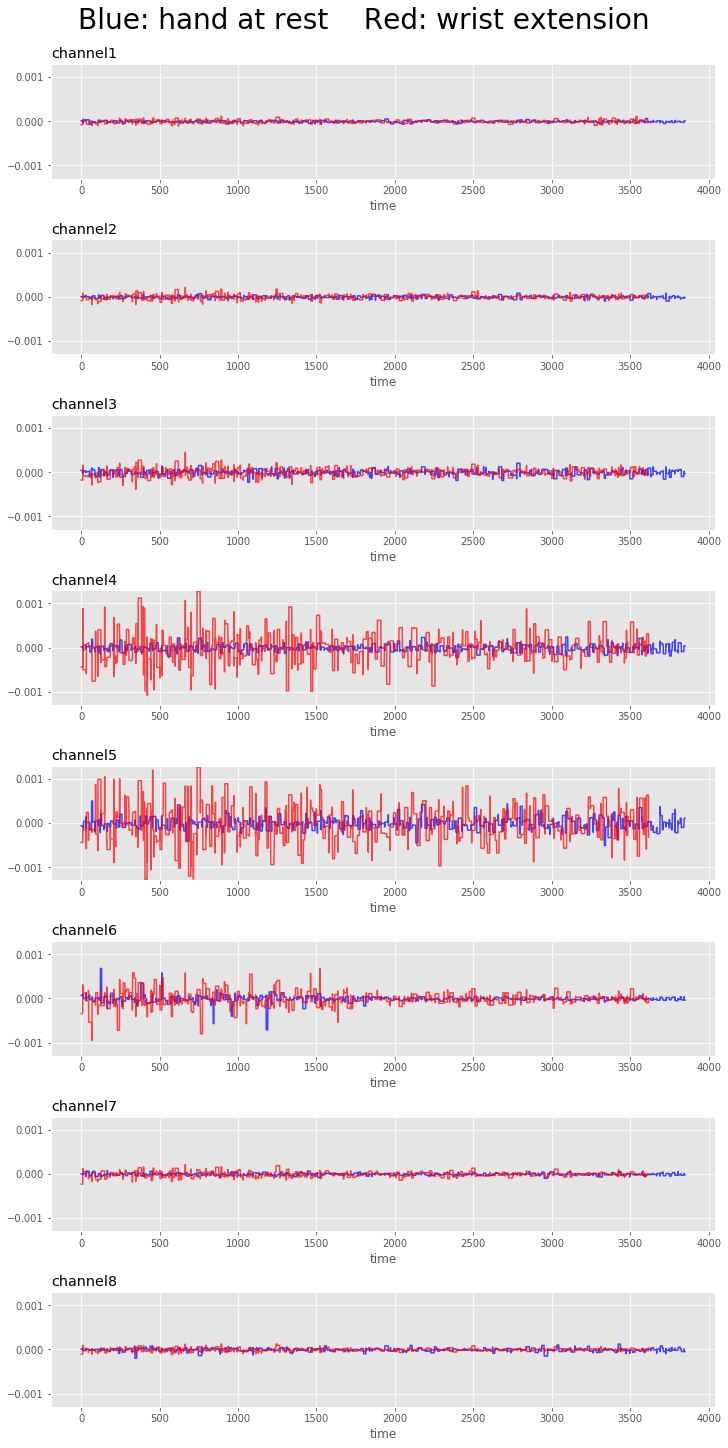

In [24]:
plot_channels_compare_gesture(m[0],1,4)

In [13]:
def plot_channels_compare_participant(data1, data2, gesture):
    # use m
    c=data1[data1['class']==gesture].drop(columns=['time',
                                     'class'])
    d=data2[data2['class']==gesture].drop(columns=['time',
                                     'class'])
    lengthc=len(c)
    lengthd=len(d)
    fig,axes=plt.subplots(8,1,figsize=(10,20),constrained_layout=True)
    for ax,col in zip(axes, c.columns):
        ax.plot(np.arange(lengthc), c[col], color='blue',alpha=.7)
        ax.set_ylim(-.0013,.0013)#rounded to complete dataset limits, see above
        ax.set_title(col, loc='left')
        ax.set_xlabel('time')
    for ax,col in zip(axes, d.columns):
        ax.plot(np.arange(lengthd), d[col], color='red',alpha=.7)
        ax.set_ylim(-.0013,.0013)#rounded to complete dataset limits, see above
    fig.suptitle(gestdict[gesture],size=28)
    plt.style.use('ggplot')
    return plt.show()

In [14]:
# channelsmin=0
# channelsmax=0
# for dataframe in o:
#     for column in dataframe.columns[:8]:
#         if dataframe[column].min() < channelsmin:
#             channelsmin = dataframe[column].min()
#         if dataframe[column].max() > channelsmax:
#             channelsmax = dataframe[column].max()
# print(channelsmin, channelsmax)

In [15]:
def plot_channels_compare_participant_mag(data1, data2, gesture):
    # use m
    c=data1[data1['class']==gesture].drop(columns=[
                                     'class'])
    d=data2[data2['class']==gesture].drop(columns=[
                                     'class'])
    lengthc=len(c)
    lengthd=len(d)
    fig,axes=plt.subplots(8,1,figsize=(10,20),constrained_layout=True)
    for ax,col in zip(axes, c.columns):
        ax.scatter(np.arange(lengthc), c[col], color='blue',alpha=.7)
        ax.set_ylim(0,.0026)#rounded to complete dataset limits, see above
        ax.set_title(col, loc='left')
        ax.set_xlabel('timebin')
        ax.set_ylabel('pseudo-mag')
    for ax,col in zip(axes, d.columns):
        ax.scatter(np.arange(lengthd), d[col], color='red',alpha=.7)
        ax.set_ylim(0,.0026)#rounded to complete dataset limits, see above
    plt.suptitle(gestdict[gesture],size=28)
    plt.style.use('ggplot')
    return plt.show()

In [16]:
from scipy.signal import welch

(-1e-12, 1e-07)

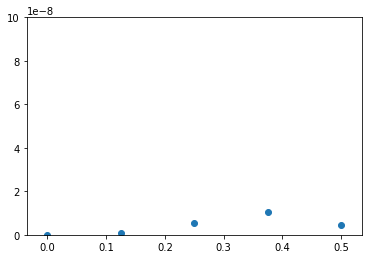

In [277]:
plt.scatter(welch(temp[0])[0],welch(temp[0])[1])
plt.ylim(-.000000000001,.0000001)
plt.style.use('ggplot')
# plt.set_ylim(.0002)

In [25]:
m=[only_gestures(x) for x in l]

In [ ]:
# obtain estimated freq and pseudo-mag

In [98]:
u=[]
for frame in m:
    t=[]
    for gesture in [frame[frame['class']==gest] for gest in [1,2,3,4,5,6]]:
        s=[]
        for splittime in [gesture[gesture['time']<gesture['time'].mean()],
                          gesture[gesture['time']>gesture['time'].mean()]]:
            r=[]
            for timebin in [splittime[len(splittime)//14*i:len(splittime)//14*i+len(splittime)//14] for i in np.arange(0,14)]:
                q=[]
                for channel in timebin.columns[1:9]:
                    w=welch(timebin[channel])
                    freq=w[0][w[1].argmax()]
                    q.append(freq)
                    mag = timebin[channel].max()-timebin[channel].min()
                    q.append(mag)
                q.append(timebin['class'].iloc[0])
                r.append(q)
            s.append(r)
        t.append(r)
    u.append(t)
del t,s,r,q

In [99]:
len(u)

71

In [78]:
len(m)

71

In [86]:
order[62]

('13', '2_raw_data_13-29_21.03.16.txt')

In [605]:
order

[('30', '2_raw_data_09-50_21.03.16.txt'),
 ('30', '1_raw_data_09-49_21.03.16.txt'),
 ('18', '1_raw_data_12-35_21.03.16.txt'),
 ('18', '2_raw_data_12-37_21.03.16.txt'),
 ('28', '2_raw_data_12-11_15.04.16.txt'),
 ('28', '1_raw_data_12-10_15.04.16.txt'),
 ('33', '1_raw_data_09-49_12.04.16.txt'),
 ('33', '2_raw_data_09-50_12.04.16.txt'),
 ('23', '1_raw_data_13-18_05.04.16.txt'),
 ('23', '2_raw_data_13-19_05.04.16.txt'),
 ('03', '1_raw_data_09-32_11.04.16.txt'),
 ('03', '2_raw_data_09-34_11.04.16.txt'),
 ('19', '1_raw_data_12-10_26.04.16.txt'),
 ('19', '2_raw_data_12-11_26.04.16.txt'),
 ('26', '1_raw_data_10-22_29.03.16.txt'),
 ('26', '2_raw_data_10-23_29.03.16.txt'),
 ('22', '2_raw_data_12-39_28.03.16.txt'),
 ('22', '1_raw_data_12-37_28.03.16.txt'),
 ('25', '1_raw_data_14-51_24.04.16.txt'),
 ('25', '2_raw_data_14-53_24.04.16.txt'),
 ('01', '2_raw_data_13-13_22.03.16.txt'),
 ('01', '1_raw_data_13-12_22.03.16.txt'),
 ('20', '2_raw_data_11-43_22.03.16.txt'),
 ('20', '1_raw_data_11-41_22.03.16

In [97]:
len(u)

34

In [101]:
z=u.copy()

In [104]:
len(z)

71

In [106]:
len(combos)

35

In [84]:
range(0,61,2)[0]

0

In [109]:
#create list of withled combinations
combos=[]
for idx in range(0,60,2):
    u=z.copy()
    test_participant=[u.pop(idx)]
    test_participant.append(u.pop(idx))
    combos.append([u,test_participant])
for idx in range(63,69,2):
    u=z.copy()
    test_participant=[u.pop(idx)]
    test_participant.append(u.pop(idx))
    combos.append([u,test_participant])

In [110]:
combos[1]

[[[[[0.007042253521126761,
     0.00010999999999999999,
     0.035211267605633804,
     0.00013000000000000002,
     0.028169014084507043,
     0.00027,
     0.007042253521126761,
     0.00025,
     0.007042253521126761,
     0.00029,
     0.014084507042253521,
     9e-05,
     0.014084507042253521,
     7e-05,
     0.014084507042253521,
     0.00012000000000000002,
     1],
    [0.014084507042253521,
     7.999999999999999e-05,
     0.007042253521126761,
     8e-05,
     0.014084507042253521,
     0.00019999999999999998,
     0.014084507042253521,
     0.00026000000000000003,
     0.007042253521126761,
     0.00047999999999999996,
     0.007042253521126761,
     7.999999999999999e-05,
     0.02112676056338028,
     6.000000000000001e-05,
     0.014084507042253521,
     0.00015999999999999999,
     1],
    [0.007042253521126761,
     7e-05,
     0.02112676056338028,
     0.00010999999999999999,
     0.007042253521126761,
     0.00023999999999999998,
     0.02112676056338028,
     0.000

In [670]:
#create witheld test participant

In [61]:
test_participant=[u.pop(6)]
test_participant.append(u.pop(6))

In [608]:
len(u)

69

In [609]:
# session -> gesture -> bin -> channel and param

In [62]:
v=[]
for session in u:
    v.append(np.concatenate(session,axis=0)) 

#     for gesture in session:
#         print(np.concatenate(gesture,axis=0))
#         break
# #         for timebin in gesture:
# #             print(np.concatenate(timebin),axis=0)
# #             break

In [63]:
x=[]
for session in test_participant:
    x.append(np.concatenate(session,axis=0))

In [64]:
test_participant_targets=[a[:,-1] for a in x]
ntest_participant_X=np.concatenate([StandardScaler().fit_transform(a[:,:-1]) 
                                                                   for a in x],
                             axis=0)
ntest_participant_y=np.concatenate(test_participant_targets, axis=0)

In [65]:
targets=[a[:,-1] for a in v] 
nX = np.concatenate([StandardScaler().fit_transform(a[:,:-1]) 
for a in v], axis=0)
ny = np.concatenate(targets,axis=0)

In [66]:
len(nX)

5796

In [26]:
# n=[make_time_bins(x,10) for x in m]

In [27]:
# o=[pseudo_magnitude(x) for x in n]

In [466]:
qqq=0
QQQ=99999
for x in range(len(m)):
    pork=len(m[x][m[x]['class']==1])
    if qqq <pork:
        qqq=pork
        print(x,'largest')
    if QQQ>pork:
        QQQ=pork
        print(x,'smallest')

0 largest
0 smallest
1 largest
2 smallest
4 smallest
5 smallest
14 largest
24 smallest


In [403]:
order[63]

('13', '1_raw_data_13-26_21.03.16.txt')

In [118]:
def plot_class_raw(dataframe):
    fig,ax=plt.subplots(1,figsize=(3,3))
    ax.plot(np.arange(len(dataframe)), dataframe['class'])
    plt.style.use('ggplot')
    plt.tight_layout()


/home/poxlox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/poxlox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/poxlox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see

/home/poxlox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/poxlox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/poxlox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see

/home/poxlox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


IndexError: list index out of range

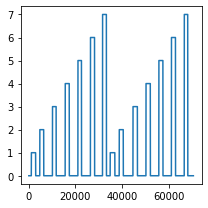

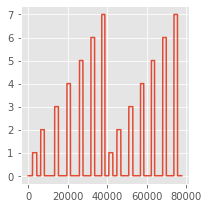

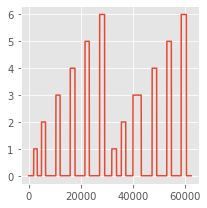

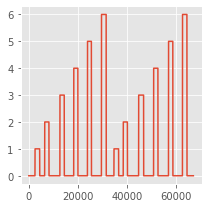

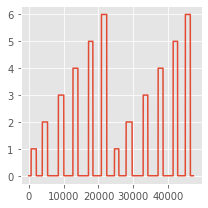

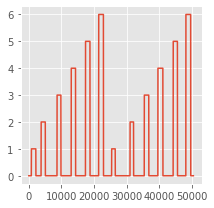

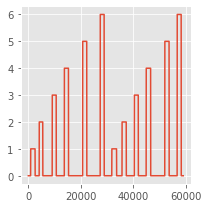

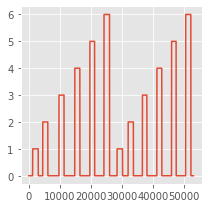

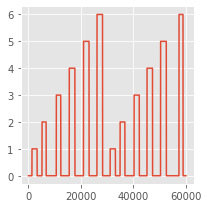

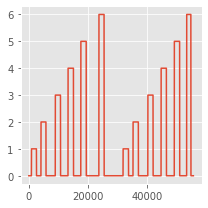

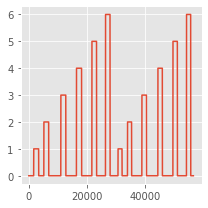

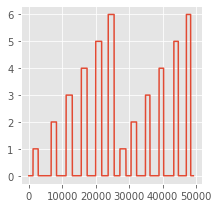

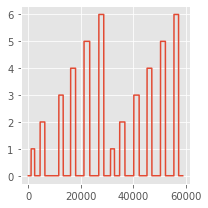

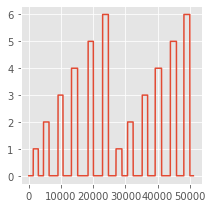

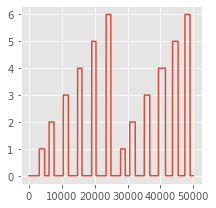

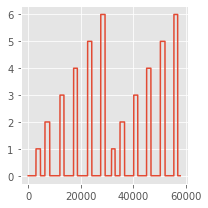

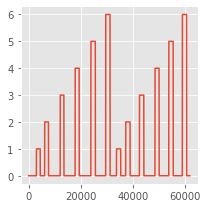

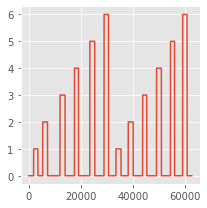

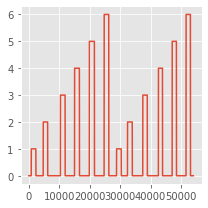

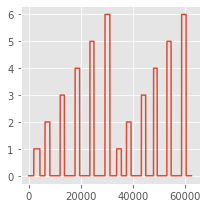

Error in callback <function flush_figures at 0x7fd0069f0840> (for post_execute):


KeyboardInterrupt: 

In [119]:
for x in range(72):
    plot_class_raw(l[x])

In [22]:
## raw pseudo-magnitudes

In [317]:
# targets=[a['class'] for a in o]
# X = pd.concat([a.drop(labels=['class'], axis=1) for a in o], axis=0,ignore_index=True)
# y = pd.concat(targets, axis=0, ignore_index=True)
# del targets

In [ ]:
## to normalize

In [630]:
# targets=[a['class'] for a in o]
# nX = np.concatenate([StandardScaler().fit_transform(a.drop(labels=['class'], axis=1)) 
# for a in o], axis=0)
# ny = pd.concat(targets,axis=0,ignore_index=True)

In [631]:
# test_participant_targets=[a['class'] for a in test_participant]
# ntest_participant_X=np.concatenate([StandardScaler().fit_transform(a.drop(labels=['class'], axis=1)) 
#                                                                    for a in test_participant],
#                              axis=0)
# ntest_participant_y=pd.concat(test_participant_targets, axis=0, ignore_index=True)

some plots

In [141]:
plot_channels(m[0],6)


In [140]:
plot_channels(m[0],5)

In [20]:
plot_channels_compare_gesture(m[0],2,3)

AttributeError: 'Figure' object has no attribute 'style'

In [29]:
plot_channels_compare_participant(n[10],n[15],2)

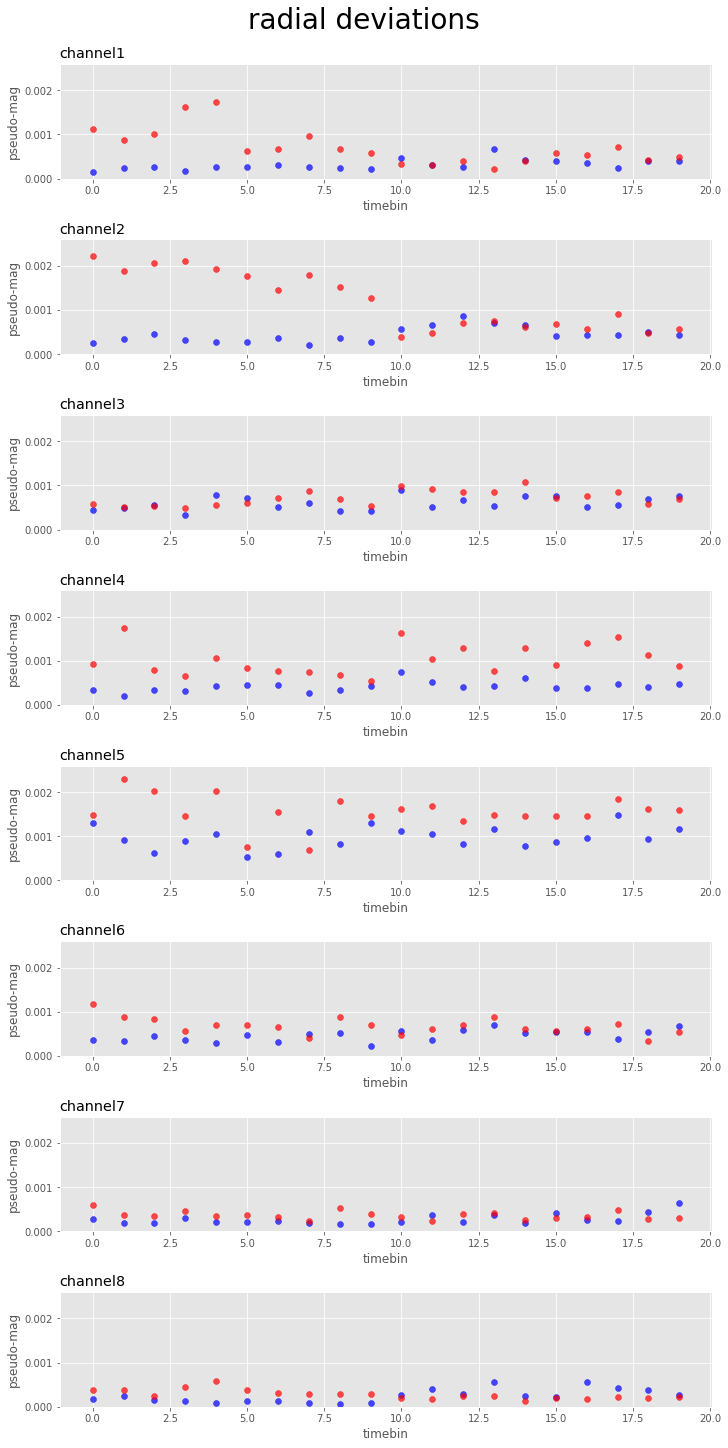

In [28]:
plot_channels_compare_participant_mag(o[5],o[10],5)

BIN CHANGE

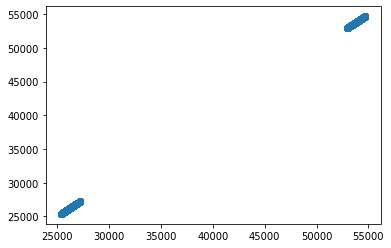

In [50]:
plot_check_motions(l[7], 6)

In [67]:
X_train,X_test,y_train,y_test=train_test_split(nX,ny)

In [672]:
#further refinement

In [674]:
parameters= {'max_depth':[5,10,15,20,None],'min_samples_leaf':[1,2,4,8],
             'max_features':['auto','sqrt'], 'bootstrap':[True,False],
             'min_samples_split':[2,3,4,6],
             'n_estimators':[110,120,130,140,200,500] }
GS=GridSearchCV(RandomForestClassifier(), parameters, n_jobs=7,verbose=1,cv=5,
                return_train_score=True)
# max_features=[3,4,5,6,7]

In [675]:
GS.fit(X_train,y_train)

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    8.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   35.4s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  2.4min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:  4.2min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed:  6.7min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed:  9.8min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed: 13.5min
[Parallel(n_jobs=7)]: Done 4036 tasks      | elapsed: 17.6min
[Parallel(n_jobs=7)]: Done 4986 tasks      | elapsed: 22.1min
[Parallel(n_jobs=7)]: Done 6036 tasks      | elapsed: 27.0min
[Parallel(n_jobs=7)]: Done 7186 tasks      | elapsed: 34.8min
[Parallel(n_jobs=7)]: Done 8436 tasks      | elapsed: 43.6min
[Parallel(n_jobs=7)]: Done 9600 out of 9600 | elapsed: 51.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [676]:
rf=GS.best_estimator_

In [677]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [678]:
rf.score(X_train,y_train)

1.0

In [679]:
rf.score(X_test,y_test)

0.9082125603864735

In [680]:
rf.score(ntest_participant_X,ntest_participant_y)

0.8452380952380952

In [ ]:
#comparing pos6-7 participant with freq and mag to just mag
# 84% to 92 fuckina


In [31]:
3000/14

214.28571428571428

In [403]:
newframe[0,-1]

1.0

In [404]:
targets=newframe[:,-1]

In [405]:
X=newframe[:,:8]

TypeError: cannot concatenate object of type "<class 'numpy.ndarray'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [406]:
X_train, X_test, y_train,y_test = train_test_split(X, targets)

In [407]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=140,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [408]:
rf.score(X_test,y_test)

0.7095908786049631

In [59]:
whos

Variable                                Type          Data/Info
---------------------------------------------------------------
Dense                                   type          <class 'keras.layers.core.Dense'>
Dropout                                 type          <class 'keras.layers.core.Dropout'>
Flatten                                 type          <class 'keras.layers.core.Flatten'>
GridSearch                              type          <class 'hypopt.model_selection.GridSearch'>
GridSearchCV                            ABCMeta       <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
RandomForestClassifier                  ABCMeta       <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
Sequential                              type          <class 'keras.engine.sequential.Sequential'>
StandardScaler                          type          <class 'sklearn.preproces<...>ing.data.StandardScaler'>
channel                                 str           channel8
df            

In [684]:
print('hello')

hello


In [ ]:
parameters= 

In [71]:
from hypopt import GridSearch

In [75]:
params = {'max_depth':[5,10,15,20,60],'min_samples_leaf':[1,2,4,8],
             'max_features':['auto','sqrt'], 'bootstrap':[True,False],
             'min_samples_split':[2,3,4,6],
             'n_estimators':[100] }

# Grid-search all parameter combinations using a validation set.
opt = GridSearch(RandomForestClassifier(),params, num_threads=6)
opt.fit(X_train, y_train, ntest_participant_X, ntest_participant_y, verbose=True)
print('Test Score for Optimized Parameters:', opt.score(X_test, y_test))

Comparing 320 parameter setting(s) using 6 CPU thread(s) ( 53 job(s) per thread ).




  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 1/320 [00:00<04:13,  1.26it/s]

  2%|▏         | 7/320 [00:01<03:02,  1.71it/s]

  3%|▎         | 9/320 [00:01<02:16,  2.29it/s]

  4%|▍         | 13/320 [00:01<01:41,  3.02it/s]

  5%|▍         | 15/320 [00:02<01:21,  3.73it/s]

  5%|▌         | 17/320 [00:02<01:05,  4.60it/s]

  6%|▌         | 19/320 [00:02<00:52,  5.78it/s]

  7%|▋         | 21/320 [00:02<00:55,  5.37it/s]

  7%|▋         | 23/320 [00:03<00:47,  6.24it/s]

  8%|▊         | 26/320 [00:03<00:38,  7.57it/s]

  9%|▉         | 28/320 [00:03<00:43,  6.75it/s]

 10%|▉         | 31/320 [00:03<00:35,  8.13it/s]

 10%|█         | 33/320 [00:04<00:45,  6.33it/s]

 11%|█         | 34/320 [00:04<00:56,  5.05it/s]

 11%|█         | 35/320 [00:04<00:59,  4.81it/s]

 12%|█▏        | 37/320 [00:05<00:48,  5.82it/s]

 12%|█▏        | 39/320 [00:05<00:39,  7.12it/s]

 13%|█▎        | 41/320 [00:05<00:53,  5.19it/s]

 13%|█▎        | 42/320 [00:06<00:56,  4.90it/s]

 14%|█▍   

Test Score for Optimized Parameters: 0.8764665286404417


In [76]:
opt.score(X_test,y_test)

0.8764665286404417

In [77]:
opt.score(ntest_participant_X,ntest_participant_y)

0.8511904761904762

In [72]:
opt.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [70]:
preds=opt.predict(X_test)
newy=y_test.to_numpy()
newy.shape=(newy.shape[0],1)
preds.shape=(preds.shape[0],1)
errorcheck = np.concatenate((preds,newy,preds-newy),axis=1)
errors=errorcheck[errorcheck[:,2]!=0]
err=pd.DataFrame(errors,columns=['pred', 'tru', 'diff'])
err.sort_values(by=['tru'])
err.groupby(by=['tru','pred'])['pred'].count().sort_values()

tru  pred
4.0  2.0      1
5.0  3.0      1
4.0  6.0      1
3.0  1.0      1
6.0  5.0      1
2.0  4.0      1
5.0  2.0      2
1.0  3.0      2
     5.0      3
3.0  2.0      4
2.0  6.0      4
3.0  5.0      5
6.0  4.0      6
     2.0      6
2.0  3.0      7
3.0  6.0     19
4.0  5.0     25
6.0  3.0     31
5.0  4.0     33
Name: pred, dtype: int64

In [69]:
## witheld participant errors, 10 bins, 88% acc on unseen
# tru  pred
# 2.0  6.0      1
# 4.0  5.0      3
# 5.0  2.0      8
# 3.0  6.0     17
# this is the best so far. The most common mistake is 
# predicting a 3 as a 6, with 17/40 wrong predictions there.
# (3 is a wrist flexion, 6 is an ulnar deviation)
# second place is precting a 5 as a 2
# (radial deviation, clenched fist)

In [ ]:
## test set errors
# 5 as 4, 6 as 3, 4 as 5, 3 as 6


In [71]:
len(newy[newy==5])

335

In [60]:
best_so_far=opt.best_estimator_

In [527]:
preds=rf.predict(ntest_participant_X)

In [528]:
newy=ntest_participant_y.to_numpy()

In [531]:
newy.shape=(newy.shape[0],1)
preds.shape=(preds.shape[0],1)

In [532]:
errorcheck = np.concatenate((preds,newy,preds-newy),axis=1)
errors=errorcheck[errorcheck[:,2]!=0]

In [533]:
err=pd.DataFrame(errors,columns=['pred', 'tru', 'diff'])
err.sort_values(by=['tru'])
err.groupby(by=['tru','pred'])['pred'].count().sort_values()

tru  pred
2.0  3.0      1
     4.0      1
3.0  2.0      1
4.0  3.0      1
5.0  3.0      1
2.0  5.0      2
4.0  2.0      2
6.0  2.0      3
5.0  2.0      7
4.0  5.0     15
3.0  6.0     37
Name: pred, dtype: int64

In [375]:
ntest_participant_X
# nX

array([[4.00e-05, 8.00e-05, 2.90e-04, 2.90e-04, 7.00e-05, 5.00e-05,
        5.00e-05, 5.00e-05],
       [4.00e-05, 6.00e-05, 3.60e-04, 2.00e-04, 6.00e-05, 6.00e-05,
        4.00e-05, 6.00e-05],
       [4.00e-05, 7.00e-05, 3.50e-04, 2.00e-04, 6.00e-05, 5.00e-05,
        4.00e-05, 4.00e-05],
       [4.00e-05, 6.00e-05, 3.70e-04, 2.20e-04, 7.00e-05, 5.00e-05,
        5.00e-05, 3.00e-05],
       [4.00e-05, 4.00e-05, 2.90e-04, 1.30e-04, 9.00e-05, 4.00e-05,
        5.00e-05, 5.00e-05],
       [4.40e-04, 1.80e-04, 2.80e-04, 1.50e-03, 1.22e-03, 3.80e-04,
        8.50e-04, 1.35e-03],
       [3.20e-04, 1.50e-04, 3.50e-04, 1.97e-03, 3.90e-04, 5.20e-04,
        9.10e-04, 8.70e-04],
       [2.80e-04, 1.40e-04, 4.80e-04, 1.38e-03, 2.10e-04, 3.00e-04,
        8.80e-04, 1.17e-03],
       [3.50e-04, 1.10e-04, 4.20e-04, 1.43e-03, 1.90e-04, 4.10e-04,
        9.40e-04, 1.06e-03],
       [2.50e-04, 1.10e-04, 4.60e-04, 1.44e-03, 1.80e-04, 3.70e-04,
        8.30e-04, 1.10e-03],
       [2.10e-04, 1.64e-03, 7.

In [102]:
rf.feature_importances_

array([0.14132033, 0.0876504 , 0.08096743, 0.13257624, 0.14448307,
       0.10955623, 0.15069708, 0.15274923])

In [ ]:
##try gradient boosting later

In [79]:
ny.shape

(8280,)

In [663]:
tpy=ntest_participant_y.to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [664]:
# scaler = StandardScaler()
# XN = scaler.fit_transform(X)
# newy = ny-1
y_binary = to_categorical(ny-1)

In [665]:
# tpX=scaler.transform(ntest_participant_X)

tpybin=to_categorical(ntest_participant_y-1)

In [666]:
y_bin_tr=to_categorical(y_train-1)
y_bin_te=to_categorical(y_test-1)

In [83]:
X_train,X_test,y_train,y_test=train_test_split(nX,y_binary)

In [669]:
model = Sequential()
model.add(Dense(128,input_dim=16,activation='relu'))
# model.add(Dense(256,activation='relu'))

# model.add(Dense(256,input_dim=8,activation='relu',
#              kernel_regularizer=l2(.5)   ))
# model.add(Dense(128,activation='relu'))
# model.add(Dense(128,activation='relu'))

# model.add(Dense(256,activation='relu'))
# model.add(Dense(3,activation='relu'))
# model.add(Dense(16,activation='relu'))
# model.add(Dense(8,activation='relu'))
model.add(Dense(6,activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='rmsprop',
              metrics=['accuracy'])
model.fit(nX,y_binary,batch_size=100,epochs=5000,
          verbose=1, validation_data=(ntest_participant_X, tpybin))

Train on 5796 samples, validate on 168 samples
Epoch 1/5000
5796/5796 [==============================] - 0s 27us/step - loss: 37.3867 - accuracy: 0.6454 - val_loss: 12.5919 - val_accuracy: 0.8690
Epoch 2/5000
5796/5796 [==============================] - 0s 12us/step - loss: 4.9813 - accuracy: 0.7918 - val_loss: 1.1638 - val_accuracy: 0.8452
Epoch 3/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.9270 - accuracy: 0.8069 - val_loss: 0.7471 - val_accuracy: 0.8155
Epoch 4/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.7601 - accuracy: 0.8233 - val_loss: 0.6531 - val_accuracy: 0.8512
Epoch 5/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.6827 - accuracy: 0.8252 - val_loss: 0.5812 - val_accuracy: 0.8810
Epoch 6/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.6360 - accuracy: 0.8339 - val_loss: 0.4976 - val_accuracy: 0.8750
Epoch 7/5000
5796/5796 [==============================] - 0s 13us/ste

5796/5796 [==============================] - 0s 13us/step - loss: 0.4450 - accuracy: 0.8644 - val_loss: 0.5329 - val_accuracy: 0.8810
Epoch 57/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.4359 - accuracy: 0.8671 - val_loss: 0.4890 - val_accuracy: 0.8512
Epoch 58/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.4471 - accuracy: 0.8677 - val_loss: 0.5189 - val_accuracy: 0.8750
Epoch 59/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.4342 - accuracy: 0.8692 - val_loss: 0.4471 - val_accuracy: 0.8869
Epoch 60/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.4346 - accuracy: 0.8689 - val_loss: 0.5844 - val_accuracy: 0.8690
Epoch 61/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.4310 - accuracy: 0.8751 - val_loss: 0.5025 - val_accuracy: 0.8750
Epoch 62/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.4361 - accuracy: 0.8678 - val_loss: 0.6561 -

5796/5796 [==============================] - 0s 11us/step - loss: 0.3643 - accuracy: 0.8884 - val_loss: 0.5428 - val_accuracy: 0.8571
Epoch 167/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.3761 - accuracy: 0.8860 - val_loss: 0.4951 - val_accuracy: 0.8393
Epoch 168/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.3651 - accuracy: 0.8865 - val_loss: 0.3841 - val_accuracy: 0.8988
Epoch 169/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.3709 - accuracy: 0.8811 - val_loss: 0.5746 - val_accuracy: 0.8690
Epoch 170/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.3783 - accuracy: 0.8815 - val_loss: 0.5812 - val_accuracy: 0.8274
Epoch 171/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.3571 - accuracy: 0.8882 - val_loss: 0.5550 - val_accuracy: 0.8512
Epoch 172/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.3718 - accuracy: 0.8804 - val_loss: 0.

5796/5796 [==============================] - 0s 13us/step - loss: 0.3494 - accuracy: 0.8923 - val_loss: 0.6382 - val_accuracy: 0.7857
Epoch 222/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.3456 - accuracy: 0.8932 - val_loss: 0.5855 - val_accuracy: 0.7917
Epoch 223/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.3560 - accuracy: 0.8870 - val_loss: 0.6271 - val_accuracy: 0.8214
Epoch 224/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.3499 - accuracy: 0.8894 - val_loss: 0.4619 - val_accuracy: 0.8690
Epoch 225/5000
5796/5796 [==============================] - 0s 14us/step - loss: 0.3463 - accuracy: 0.8932 - val_loss: 0.5652 - val_accuracy: 0.7917
Epoch 226/5000
5796/5796 [==============================] - 0s 14us/step - loss: 0.3489 - accuracy: 0.8911 - val_loss: 0.6201 - val_accuracy: 0.7679
Epoch 227/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.3480 - accuracy: 0.8937 - val_loss: 0.

5796/5796 [==============================] - 0s 13us/step - loss: 0.3352 - accuracy: 0.8949 - val_loss: 0.4363 - val_accuracy: 0.8810
Epoch 277/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.3403 - accuracy: 0.8942 - val_loss: 0.4488 - val_accuracy: 0.8810
Epoch 278/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.3352 - accuracy: 0.8910 - val_loss: 0.5931 - val_accuracy: 0.8393
Epoch 279/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.3345 - accuracy: 0.8956 - val_loss: 0.5403 - val_accuracy: 0.8393
Epoch 280/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.3356 - accuracy: 0.8961 - val_loss: 0.5147 - val_accuracy: 0.8690
Epoch 281/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.3384 - accuracy: 0.8942 - val_loss: 0.5157 - val_accuracy: 0.8631
Epoch 282/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.3399 - accuracy: 0.8922 - val_loss: 0.

5796/5796 [==============================] - 0s 13us/step - loss: 0.3203 - accuracy: 0.8982 - val_loss: 0.4608 - val_accuracy: 0.8869
Epoch 332/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.3285 - accuracy: 0.8987 - val_loss: 0.5693 - val_accuracy: 0.8393
Epoch 333/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.3240 - accuracy: 0.8992 - val_loss: 0.5485 - val_accuracy: 0.8571
Epoch 334/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.3204 - accuracy: 0.9004 - val_loss: 0.4695 - val_accuracy: 0.8512
Epoch 335/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.3149 - accuracy: 0.9006 - val_loss: 0.5855 - val_accuracy: 0.8631
Epoch 336/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.3209 - accuracy: 0.8986 - val_loss: 0.5638 - val_accuracy: 0.8333
Epoch 337/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.3239 - accuracy: 0.8994 - val_loss: 0.

Epoch 441/5000
5796/5796 [==============================] - 0s 15us/step - loss: 0.3053 - accuracy: 0.9086 - val_loss: 0.6531 - val_accuracy: 0.8393
Epoch 442/5000
5796/5796 [==============================] - 0s 14us/step - loss: 0.3034 - accuracy: 0.9049 - val_loss: 0.5219 - val_accuracy: 0.8512
Epoch 443/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2995 - accuracy: 0.9072 - val_loss: 0.4922 - val_accuracy: 0.8690
Epoch 444/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2960 - accuracy: 0.9075 - val_loss: 0.4966 - val_accuracy: 0.8690
Epoch 445/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.3020 - accuracy: 0.9082 - val_loss: 0.5733 - val_accuracy: 0.8571
Epoch 446/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.2989 - accuracy: 0.9039 - val_loss: 0.5123 - val_accuracy: 0.8452
Epoch 447/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.3007 - accuracy: 0.9125

Epoch 496/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2901 - accuracy: 0.9106 - val_loss: 0.6749 - val_accuracy: 0.8452
Epoch 497/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2902 - accuracy: 0.9108 - val_loss: 0.5750 - val_accuracy: 0.8333
Epoch 498/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2885 - accuracy: 0.9092 - val_loss: 0.4987 - val_accuracy: 0.8690
Epoch 499/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2890 - accuracy: 0.9106 - val_loss: 0.7309 - val_accuracy: 0.7976
Epoch 500/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2929 - accuracy: 0.9056 - val_loss: 0.5480 - val_accuracy: 0.8512
Epoch 501/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2912 - accuracy: 0.9120 - val_loss: 0.5155 - val_accuracy: 0.8631
Epoch 502/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2859 - accuracy: 0.9125

Epoch 551/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2871 - accuracy: 0.9134 - val_loss: 0.6345 - val_accuracy: 0.8333
Epoch 552/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2812 - accuracy: 0.9161 - val_loss: 0.5737 - val_accuracy: 0.8631
Epoch 553/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2812 - accuracy: 0.9144 - val_loss: 0.5963 - val_accuracy: 0.8333
Epoch 554/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2818 - accuracy: 0.9172 - val_loss: 0.5757 - val_accuracy: 0.8512
Epoch 555/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2848 - accuracy: 0.9137 - val_loss: 0.6600 - val_accuracy: 0.8452
Epoch 556/5000
5796/5796 [==============================] - 0s 14us/step - loss: 0.2831 - accuracy: 0.9153 - val_loss: 0.5034 - val_accuracy: 0.8452
Epoch 557/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2874 - accuracy: 0.9141

Epoch 606/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2723 - accuracy: 0.9163 - val_loss: 0.5844 - val_accuracy: 0.8274
Epoch 607/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.2815 - accuracy: 0.9184 - val_loss: 0.4120 - val_accuracy: 0.8631
Epoch 608/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.2721 - accuracy: 0.9187 - val_loss: 0.6969 - val_accuracy: 0.7976
Epoch 609/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2742 - accuracy: 0.9151 - val_loss: 0.6197 - val_accuracy: 0.8452
Epoch 610/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2761 - accuracy: 0.9184 - val_loss: 0.5283 - val_accuracy: 0.8571
Epoch 611/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2753 - accuracy: 0.9161 - val_loss: 0.4696 - val_accuracy: 0.8393
Epoch 612/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2775 - accuracy: 0.9168

Epoch 661/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2719 - accuracy: 0.9189 - val_loss: 0.6270 - val_accuracy: 0.8571
Epoch 662/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2708 - accuracy: 0.9149 - val_loss: 0.5335 - val_accuracy: 0.8631
Epoch 663/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2650 - accuracy: 0.9199 - val_loss: 0.6304 - val_accuracy: 0.8393
Epoch 664/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2727 - accuracy: 0.9167 - val_loss: 0.5365 - val_accuracy: 0.8512
Epoch 665/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2670 - accuracy: 0.9203 - val_loss: 0.6219 - val_accuracy: 0.8393
Epoch 666/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2669 - accuracy: 0.9194 - val_loss: 0.5485 - val_accuracy: 0.8452
Epoch 667/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2733 - accuracy: 0.9186

Epoch 716/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2590 - accuracy: 0.9263 - val_loss: 0.5685 - val_accuracy: 0.8512
Epoch 717/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.2633 - accuracy: 0.9239 - val_loss: 0.6574 - val_accuracy: 0.8512
Epoch 718/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2638 - accuracy: 0.9231 - val_loss: 0.5879 - val_accuracy: 0.8333
Epoch 719/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2598 - accuracy: 0.9253 - val_loss: 0.6012 - val_accuracy: 0.8631
Epoch 720/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2619 - accuracy: 0.9236 - val_loss: 0.5243 - val_accuracy: 0.8512
Epoch 721/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2621 - accuracy: 0.9237 - val_loss: 0.5100 - val_accuracy: 0.8631
Epoch 722/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.2561 - accuracy: 0.9234

Epoch 771/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2571 - accuracy: 0.9263 - val_loss: 0.7026 - val_accuracy: 0.8452
Epoch 772/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2552 - accuracy: 0.9275 - val_loss: 0.6103 - val_accuracy: 0.8214
Epoch 773/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2577 - accuracy: 0.9262 - val_loss: 0.5271 - val_accuracy: 0.8631
Epoch 774/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2551 - accuracy: 0.9253 - val_loss: 0.5238 - val_accuracy: 0.8750
Epoch 775/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2575 - accuracy: 0.9229 - val_loss: 0.6225 - val_accuracy: 0.8690
Epoch 776/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2591 - accuracy: 0.9237 - val_loss: 0.5927 - val_accuracy: 0.8274
Epoch 777/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2571 - accuracy: 0.9229

Epoch 826/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2496 - accuracy: 0.9296 - val_loss: 0.5968 - val_accuracy: 0.8393
Epoch 827/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2513 - accuracy: 0.9275 - val_loss: 0.5718 - val_accuracy: 0.8333
Epoch 828/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2486 - accuracy: 0.9275 - val_loss: 0.5223 - val_accuracy: 0.8512
Epoch 829/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2417 - accuracy: 0.9267 - val_loss: 0.5732 - val_accuracy: 0.8512
Epoch 830/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2501 - accuracy: 0.9308 - val_loss: 0.6330 - val_accuracy: 0.8393
Epoch 831/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.2522 - accuracy: 0.9265 - val_loss: 0.4683 - val_accuracy: 0.8631
Epoch 832/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2524 - accuracy: 0.9243

Epoch 881/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2412 - accuracy: 0.9286 - val_loss: 0.6410 - val_accuracy: 0.8571
Epoch 882/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2488 - accuracy: 0.9282 - val_loss: 0.5642 - val_accuracy: 0.8512
Epoch 883/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2449 - accuracy: 0.9249 - val_loss: 0.5302 - val_accuracy: 0.8750
Epoch 884/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2489 - accuracy: 0.9267 - val_loss: 0.6029 - val_accuracy: 0.8274
Epoch 885/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2444 - accuracy: 0.9334 - val_loss: 0.7914 - val_accuracy: 0.8155
Epoch 886/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2409 - accuracy: 0.9303 - val_loss: 0.6155 - val_accuracy: 0.8393
Epoch 887/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2493 - accuracy: 0.9300

Epoch 936/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2432 - accuracy: 0.9315 - val_loss: 0.6454 - val_accuracy: 0.8452
Epoch 937/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2336 - accuracy: 0.9324 - val_loss: 0.5474 - val_accuracy: 0.8810
Epoch 938/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2373 - accuracy: 0.9341 - val_loss: 0.4817 - val_accuracy: 0.8869
Epoch 939/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2334 - accuracy: 0.9350 - val_loss: 0.8147 - val_accuracy: 0.7857
Epoch 940/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2387 - accuracy: 0.9346 - val_loss: 0.4361 - val_accuracy: 0.8750
Epoch 941/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2352 - accuracy: 0.9315 - val_loss: 0.6115 - val_accuracy: 0.8690
Epoch 942/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2357 - accuracy: 0.9331

Epoch 991/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2290 - accuracy: 0.9374 - val_loss: 0.5490 - val_accuracy: 0.8571
Epoch 992/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2296 - accuracy: 0.9356 - val_loss: 0.5216 - val_accuracy: 0.8571
Epoch 993/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2327 - accuracy: 0.9353 - val_loss: 0.6451 - val_accuracy: 0.8452
Epoch 994/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2282 - accuracy: 0.9370 - val_loss: 0.5606 - val_accuracy: 0.8631
Epoch 995/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2377 - accuracy: 0.9344 - val_loss: 0.5940 - val_accuracy: 0.8452
Epoch 996/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2286 - accuracy: 0.9353 - val_loss: 0.5347 - val_accuracy: 0.8631
Epoch 997/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2313 - accuracy: 0.9350

Epoch 1100/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.2210 - accuracy: 0.9393 - val_loss: 0.7078 - val_accuracy: 0.8571
Epoch 1101/5000
5796/5796 [==============================] - 0s 14us/step - loss: 0.2207 - accuracy: 0.9382 - val_loss: 0.6669 - val_accuracy: 0.8512
Epoch 1102/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.2220 - accuracy: 0.9391 - val_loss: 0.7437 - val_accuracy: 0.8095
Epoch 1103/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2177 - accuracy: 0.9427 - val_loss: 0.6669 - val_accuracy: 0.8571
Epoch 1104/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2185 - accuracy: 0.9400 - val_loss: 0.6445 - val_accuracy: 0.8393
Epoch 1105/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2219 - accuracy: 0.9386 - val_loss: 0.6322 - val_accuracy: 0.8571
Epoch 1106/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2203 - accuracy:

Epoch 1209/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2125 - accuracy: 0.9431 - val_loss: 0.6551 - val_accuracy: 0.8631
Epoch 1210/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2114 - accuracy: 0.9451 - val_loss: 0.6578 - val_accuracy: 0.8214
Epoch 1211/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2054 - accuracy: 0.9470 - val_loss: 0.7126 - val_accuracy: 0.8274
Epoch 1212/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2129 - accuracy: 0.9444 - val_loss: 0.6484 - val_accuracy: 0.8512
Epoch 1213/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2115 - accuracy: 0.9422 - val_loss: 0.6295 - val_accuracy: 0.8452
Epoch 1214/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2089 - accuracy: 0.9441 - val_loss: 0.7136 - val_accuracy: 0.8571
Epoch 1215/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2151 - accuracy:

Epoch 1318/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1968 - accuracy: 0.9493 - val_loss: 0.5787 - val_accuracy: 0.8631
Epoch 1319/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2041 - accuracy: 0.9479 - val_loss: 0.6859 - val_accuracy: 0.8452
Epoch 1320/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1990 - accuracy: 0.9488 - val_loss: 0.6511 - val_accuracy: 0.8631
Epoch 1321/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.2045 - accuracy: 0.9477 - val_loss: 0.6411 - val_accuracy: 0.8452
Epoch 1322/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1988 - accuracy: 0.9494 - val_loss: 0.6376 - val_accuracy: 0.8512
Epoch 1323/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.2039 - accuracy: 0.9458 - val_loss: 0.6447 - val_accuracy: 0.8512
Epoch 1324/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1969 - accuracy:

Epoch 1427/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1895 - accuracy: 0.9512 - val_loss: 0.7037 - val_accuracy: 0.8452
Epoch 1428/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1907 - accuracy: 0.9527 - val_loss: 0.7880 - val_accuracy: 0.8393
Epoch 1429/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1872 - accuracy: 0.9520 - val_loss: 0.7196 - val_accuracy: 0.8512
Epoch 1430/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1904 - accuracy: 0.9500 - val_loss: 0.7521 - val_accuracy: 0.8571
Epoch 1431/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1909 - accuracy: 0.9510 - val_loss: 0.6412 - val_accuracy: 0.8571
Epoch 1432/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1833 - accuracy: 0.9545 - val_loss: 0.6877 - val_accuracy: 0.8452
Epoch 1433/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.1940 - accuracy:

Epoch 1536/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1755 - accuracy: 0.9565 - val_loss: 0.7722 - val_accuracy: 0.8393
Epoch 1537/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1781 - accuracy: 0.9572 - val_loss: 0.8505 - val_accuracy: 0.8274
Epoch 1538/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1802 - accuracy: 0.9527 - val_loss: 0.7726 - val_accuracy: 0.8631
Epoch 1539/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1767 - accuracy: 0.9588 - val_loss: 0.6643 - val_accuracy: 0.8571
Epoch 1540/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1760 - accuracy: 0.9557 - val_loss: 0.9159 - val_accuracy: 0.8095
Epoch 1541/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1811 - accuracy: 0.9536 - val_loss: 0.8255 - val_accuracy: 0.8274
Epoch 1542/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1786 - accuracy:

Epoch 1645/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1723 - accuracy: 0.9579 - val_loss: 0.8940 - val_accuracy: 0.7917
Epoch 1646/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1703 - accuracy: 0.9579 - val_loss: 0.8119 - val_accuracy: 0.8452
Epoch 1647/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1716 - accuracy: 0.9576 - val_loss: 0.7929 - val_accuracy: 0.8155
Epoch 1648/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1704 - accuracy: 0.9608 - val_loss: 0.6865 - val_accuracy: 0.8571
Epoch 1649/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1689 - accuracy: 0.9577 - val_loss: 0.8205 - val_accuracy: 0.8393
Epoch 1650/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1680 - accuracy: 0.9598 - val_loss: 0.9402 - val_accuracy: 0.8452
Epoch 1651/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1670 - accuracy:

Epoch 1754/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1643 - accuracy: 0.9641 - val_loss: 1.0107 - val_accuracy: 0.8333
Epoch 1755/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1610 - accuracy: 0.9645 - val_loss: 0.7763 - val_accuracy: 0.8571
Epoch 1756/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1628 - accuracy: 0.9617 - val_loss: 0.6570 - val_accuracy: 0.8631
Epoch 1757/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.1638 - accuracy: 0.9582 - val_loss: 0.8534 - val_accuracy: 0.8690
Epoch 1758/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1650 - accuracy: 0.9627 - val_loss: 0.6643 - val_accuracy: 0.8631
Epoch 1759/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1644 - accuracy: 0.9591 - val_loss: 0.6788 - val_accuracy: 0.8690
Epoch 1760/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1616 - accuracy:

Epoch 1863/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1546 - accuracy: 0.9677 - val_loss: 0.8132 - val_accuracy: 0.8631
Epoch 1864/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1647 - accuracy: 0.9603 - val_loss: 0.8996 - val_accuracy: 0.8333
Epoch 1865/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1533 - accuracy: 0.9615 - val_loss: 0.8796 - val_accuracy: 0.8571
Epoch 1866/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1550 - accuracy: 0.9643 - val_loss: 0.6750 - val_accuracy: 0.8571
Epoch 1867/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1618 - accuracy: 0.9629 - val_loss: 0.8518 - val_accuracy: 0.8512
Epoch 1868/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1556 - accuracy: 0.9636 - val_loss: 0.8099 - val_accuracy: 0.8571
Epoch 1869/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1570 - accuracy:

Epoch 1972/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1510 - accuracy: 0.9660 - val_loss: 1.1059 - val_accuracy: 0.8274
Epoch 1973/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1484 - accuracy: 0.9646 - val_loss: 0.9139 - val_accuracy: 0.8214
Epoch 1974/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1547 - accuracy: 0.9636 - val_loss: 0.8432 - val_accuracy: 0.8571
Epoch 1975/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1475 - accuracy: 0.9679 - val_loss: 0.9083 - val_accuracy: 0.8512
Epoch 1976/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1503 - accuracy: 0.9665 - val_loss: 0.8885 - val_accuracy: 0.8512
Epoch 1977/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1515 - accuracy: 0.9657 - val_loss: 0.9799 - val_accuracy: 0.8452
Epoch 1978/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1481 - accuracy:

Epoch 2081/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1445 - accuracy: 0.9695 - val_loss: 0.9155 - val_accuracy: 0.8393
Epoch 2082/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1496 - accuracy: 0.9683 - val_loss: 0.8869 - val_accuracy: 0.8452
Epoch 2083/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1440 - accuracy: 0.9683 - val_loss: 0.8661 - val_accuracy: 0.8631
Epoch 2084/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1471 - accuracy: 0.9676 - val_loss: 0.9701 - val_accuracy: 0.8214
Epoch 2085/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1448 - accuracy: 0.9703 - val_loss: 0.7516 - val_accuracy: 0.8631
Epoch 2086/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1444 - accuracy: 0.9695 - val_loss: 0.8508 - val_accuracy: 0.8571
Epoch 2087/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1426 - accuracy:

Epoch 2190/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1380 - accuracy: 0.9702 - val_loss: 0.9323 - val_accuracy: 0.8333
Epoch 2191/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1410 - accuracy: 0.9684 - val_loss: 0.8285 - val_accuracy: 0.8690
Epoch 2192/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1411 - accuracy: 0.9684 - val_loss: 1.0676 - val_accuracy: 0.8393
Epoch 2193/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1345 - accuracy: 0.9719 - val_loss: 0.9539 - val_accuracy: 0.8452
Epoch 2194/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1408 - accuracy: 0.9717 - val_loss: 0.8106 - val_accuracy: 0.8571
Epoch 2195/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1411 - accuracy: 0.9676 - val_loss: 0.9053 - val_accuracy: 0.8631
Epoch 2196/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1385 - accuracy:

Epoch 2299/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1381 - accuracy: 0.9719 - val_loss: 0.9842 - val_accuracy: 0.8333
Epoch 2300/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1381 - accuracy: 0.9705 - val_loss: 1.0940 - val_accuracy: 0.8393
Epoch 2301/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1422 - accuracy: 0.9681 - val_loss: 1.0418 - val_accuracy: 0.8214
Epoch 2302/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1318 - accuracy: 0.9743 - val_loss: 0.8240 - val_accuracy: 0.8631
Epoch 2303/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1392 - accuracy: 0.9686 - val_loss: 0.9092 - val_accuracy: 0.8095
Epoch 2304/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1367 - accuracy: 0.9724 - val_loss: 0.8684 - val_accuracy: 0.8274
Epoch 2305/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1333 - accuracy:

Epoch 2408/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1349 - accuracy: 0.9715 - val_loss: 1.1650 - val_accuracy: 0.8333
Epoch 2409/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1312 - accuracy: 0.9752 - val_loss: 0.8720 - val_accuracy: 0.8452
Epoch 2410/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1296 - accuracy: 0.9736 - val_loss: 0.6978 - val_accuracy: 0.8571
Epoch 2411/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1301 - accuracy: 0.9736 - val_loss: 0.9883 - val_accuracy: 0.8571
Epoch 2412/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1316 - accuracy: 0.9752 - val_loss: 1.2133 - val_accuracy: 0.7560
Epoch 2413/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1357 - accuracy: 0.9708 - val_loss: 0.9608 - val_accuracy: 0.8512
Epoch 2414/5000
5796/5796 [==============================] - 0s 10us/step - loss: 0.1341 - accuracy:

Epoch 2517/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1288 - accuracy: 0.9752 - val_loss: 0.9786 - val_accuracy: 0.8452
Epoch 2518/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1283 - accuracy: 0.9739 - val_loss: 0.8933 - val_accuracy: 0.8512
Epoch 2519/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1338 - accuracy: 0.9736 - val_loss: 1.2473 - val_accuracy: 0.8095
Epoch 2520/5000
5796/5796 [==============================] - 0s 14us/step - loss: 0.1284 - accuracy: 0.9758 - val_loss: 1.0387 - val_accuracy: 0.8214
Epoch 2521/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.1261 - accuracy: 0.9750 - val_loss: 1.0328 - val_accuracy: 0.8452
Epoch 2522/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.1319 - accuracy: 0.9733 - val_loss: 0.9828 - val_accuracy: 0.8512
Epoch 2523/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1331 - accuracy:

Epoch 2626/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1285 - accuracy: 0.9736 - val_loss: 1.1206 - val_accuracy: 0.8155
Epoch 2627/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1252 - accuracy: 0.9755 - val_loss: 0.9707 - val_accuracy: 0.8512
Epoch 2628/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1255 - accuracy: 0.9743 - val_loss: 0.6868 - val_accuracy: 0.8512
Epoch 2629/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1306 - accuracy: 0.9726 - val_loss: 0.9523 - val_accuracy: 0.8452
Epoch 2630/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1278 - accuracy: 0.9762 - val_loss: 1.0322 - val_accuracy: 0.8095
Epoch 2631/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1241 - accuracy: 0.9746 - val_loss: 0.8503 - val_accuracy: 0.8571
Epoch 2632/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1261 - accuracy:

Epoch 2735/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1230 - accuracy: 0.9783 - val_loss: 1.0554 - val_accuracy: 0.8333
Epoch 2736/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.1230 - accuracy: 0.9745 - val_loss: 0.9992 - val_accuracy: 0.8452
Epoch 2737/5000
5796/5796 [==============================] - 0s 14us/step - loss: 0.1269 - accuracy: 0.9757 - val_loss: 0.9353 - val_accuracy: 0.8333
Epoch 2738/5000
5796/5796 [==============================] - 0s 13us/step - loss: 0.1292 - accuracy: 0.9752 - val_loss: 1.0785 - val_accuracy: 0.8333
Epoch 2739/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1235 - accuracy: 0.9755 - val_loss: 0.9877 - val_accuracy: 0.8452
Epoch 2740/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1240 - accuracy: 0.9764 - val_loss: 1.0290 - val_accuracy: 0.8214
Epoch 2741/5000
5796/5796 [==============================] - 0s 11us/step - loss: 0.1222 - accuracy:

Epoch 2844/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.1176 - accuracy: 0.9769 - val_loss: 1.0019 - val_accuracy: 0.8214
Epoch 2845/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.1267 - accuracy: 0.9715 - val_loss: 0.9762 - val_accuracy: 0.8512
Epoch 2846/5000
5796/5796 [==============================] - 0s 12us/step - loss: 0.1264 - accuracy: 0.9776 - val_loss: 1.0218 - val_accuracy: 0.8512
Epoch 2847/5000
4300/5796 [=====================>........] - ETA: 0s - loss: 0.1161 - accuracy: 0.9788

KeyboardInterrupt: 

In [347]:
scores = model.evaluate(tpX, tpybin, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

120/120 [==============================] - 0s 41us/step
accuracy: 65.83%


In [345]:
len(tpybin)

4200

In [156]:
preds=model.predict(ntest_participant_X)
newy=tpybin
# newy.shape=(newy.shape[0],1)
# preds.shape=(preds.shape[0],1)
errorcheck = np.concatenate((preds,newy,preds-newy),axis=1)
errors=errorcheck[errorcheck[:,2]!=0]
err=pd.DataFrame(errors,columns=['pred', 'tru', 'diff'])
err.sort_values(by=['tru'])
err.groupby(by=['tru','pred'])['pred'].count().sort_values()

ValueError: Shape of passed values is (240, 18), indices imply (240, 3)

In [108]:
preds = model.predict_classes(XN)
newy = newy.to_numpy()
preds.shape=(preds.shape,1)
newy.shape=(newy.shape,1)

In [113]:
errorcheck = np.concatenate((preds,newy,preds-newy),axis=1)

In [115]:
errors=errorcheck[errorcheck[:,2]!=0]

In [119]:
len(errors)

277

In [123]:
err=pd.DataFrame(errors,columns=['pred', 'tru', 'diff'])

In [131]:
err=pd.DataFrame(errors,columns=['pred', 'tru', 'diff'])
err.sort_values(by=['tru'])

pred  tru  diff
16      1    0     1
144     4    0     4
10      2    0     2
133     2    0     2
31      2    0     2
257     5    1     4
258     0    1    -1
259     2    1     1
239     2    1     1
97      2    1     1
252     5    1     4
244     0    1    -1
39      2    1     1
256     5    1     4
188     2    1     1
98      2    1     1
245     0    1    -1
251     5    1     4
181     2    1     1
150     2    1     1
152     2    1     1
42      2    1     1
156     2    1     1
225     4    1     3
159     2    1     1
160     2    1     1
271     5    1     4
161     2    1     1
162     2    1     1
116     2    1     1
..    ...  ...   ...
182     2    5    -3
176     2    5    -3
164     2    5    -3
165     2    5    -3
170     2    5    -3
169     2    5    -3
168     2    5    -3
198     2    5    -3
65      2    5    -3
112     1    5    -4
205     2    5    -3
68      2    5    -3
69      2    5    -3
70      2    5    -3
72      2    5    -3
73      2    5    -3
74      2    5    -3
75      2    5    -3
76      2    5    -3
77      2    5    -3
78      2    5    -3
166     2    5    -3
220     2    5    -3
89      3    5    -2
91      2    5    -3
215     2    5    -3
99      2    5    -3
101     2    5    -3
204     2    5    -3
79      2    5    -3

[277 rows x 3 columns]

In [140]:
err.groupby(by='tru')['pred'].count().sort_values()

tru
0     5
1    27
3    43
5    61
2    69
4    72
Name: pred, dtype: int64

worst performance: 4, 2, 5  
    radial deviations, wrist flexion, ulnar deviations  
med: 3  
    wrist extension  
best performance: 0,1  
    hand at rest, hand clenched

In [141]:
err.groupby(by=['tru','pred'])['pred'].count()

tru  pred
0    1        1
     2        3
     4        1
1    0        4
     2       16
     4        1
     5        6
2    0        3
     1        3
     3        4
     4        4
     5       55
3    4       32
     5       11
4    0        7
     2        1
     3       64
5    1        2
     2       50
     3        9
Name: pred, dtype: int64

most common prediction mishaps  
true: 4, predict: 3  
true: 2, predict: 5  
true: 5, predict: 2  
true: 3, predict: 4  
otherwise known as:  
(radial deviations, wrist extension)  
(wrist flexion, ulnar deviation)  
(ulnar deviation, wrist flexion)  
(wrist extension, radial deviation)

In [142]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [662]:
model = Sequential()
model.add(Dense(128,input_dim=8,activation='relu',))
# model.add(Dense(32,input_dim=8,activation='relu',
#              kernel_regularizer=l2(.5)   ))
model.add(Dense(128,activation='relu',kernel_regularizer=l2(.001)))
model.add(Dense(64,activation='relu'))
model.add(Dense(16,activation='relu'))
# model.add(Dense(8,activation='relu'))
model.add(Dense(6,activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='rmsprop',
              metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=100,epochs=5000,
          verbose=1, validation_data=(X_test, y_test))

ValueError: Error when checking input: expected dense_175_input to have shape (8,) but got array with shape (16,)

In [135]:
from sklearn.ensemble import GradientBoostingClassifier

In [136]:
GBC=GradientBoostingClassifier()

In [139]:
GBC.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [140]:
GBC.score(X_test,y_test)

0.9130434782608695

In [143]:
ntest_participant_y

TypeError: cannot concatenate object of type "<class 'numpy.ndarray'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [146]:
GBC.score(ntest_participant_X,ntest_participant_y)

0.8541666666666666

In [659]:
param_grid = {'max_depth':[12,13,14],'min_samples_leaf':[2,3,4,5], 'learning_rate':[.01,.05,.1],
             'min_samples_split':[2,3,4], 'n_estimators':[100,110,120] }

# Grid-search all parameter combinations using a validation set.
opt = GridSearch(GradientBoostingClassifier(),param_grid, num_threads=7)
opt.fit(X_train, y_train, ntest_participant_X, ntest_participant_y)
print('Test Score for Optimized Parameters:', opt.score(X_test, y_test))

100%|██████████| 324/324 [25:27<00:00,  2.37s/it] 


Test Score for Optimized Parameters: 0.883367839889579


In [660]:
opt.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=12,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=5, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [661]:
opt.score(ntest_participant_X,ntest_participant_y)

0.8869047619047619